In [1]:
import polars as pl
import sys

sys.path.append("..")

from components.data_ingestion import DataIngestion
from components.data_preprocessing import DataPreprocessing
from components.feature_engineering import FeatureEngineering

# Large Dataset
file_list = [
    "../data/fhvhv_tripdata_2021-01.parquet",
    "../data/fhvhv_tripdata_2021-02.parquet",
    "../data/fhvhv_tripdata_2021-03.parquet",
    "../data/fhvhv_tripdata_2021-04.parquet",
    "../data/fhvhv_tripdata_2021-05.parquet",
    "../data/fhvhv_tripdata_2021-06.parquet",
    "../data/fhvhv_tripdata_2021-07.parquet",
    "../data/fhvhv_tripdata_2021-08.parquet",
    "../data/fhvhv_tripdata_2021-09.parquet",
    "../data/fhvhv_tripdata_2021-10.parquet",
    "../data/fhvhv_tripdata_2021-11.parquet",
    "../data/fhvhv_tripdata_2021-12.parquet",
]

# Create an instance of the DataIngestion class
data_ingestor = DataIngestion(file_list, batch_size=5_000_000)

In [2]:
from my_utils.data_utils import Preprocess
nyc = pl.read_csv("../data/nyc 2021-01-01 to 2021-12-31.csv").pipe(Preprocess.reduce_memory_usage)
nyc = nyc.drop(['preciptype','severerisk', 'name', 'address', 'resolvedAddress', 'windgust'])
nyc = nyc.with_columns(nyc['datetime'].cast(pl.Date))
nyc.head()

Memory usage before: 0.06 MB
Memory usage after: 0.04 MB


datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
date,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,i32
2021-01-01,2.5,-0.2,-3.0,67.800003,15.33,100,0.0,0.0,15.5,69.800003,1028.900024,50.599998,14.0,3
2021-01-02,5.8,3.6,1.2,74.0,2.38,100,1.9,0.6,25.5,246.899994,1012.400024,63.900002,12.2,5
2021-01-03,2.5,-1.6,-0.5,80.699997,5.09,100,1.2,1.7,24.1,66.400002,1017.0,81.5,13.2,1
2021-01-04,3.6,1.1,-0.2,76.599998,0.84,100,0.5,0.7,17.299999,141.100006,1014.599976,89.300003,15.6,4
2021-01-05,3.8,1.3,-1.5,68.699997,0.0,0,0.0,0.1,15.2,124.400002,1013.099976,98.800003,16.0,2


In [3]:
from tqdm import tqdm

# Add tqdm to the loop to show progress
for i, batch in tqdm(enumerate(data_ingestor), total=len(data_ingestor), desc="Processing Batches"):
    
    # Apply Preprocessing
    clean_batch = DataPreprocessing.preprocess(batch)
    
    # Join the data with the weather data
    data = clean_batch.join(nyc, left_on='dropoff_date', right_on='datetime', how = 'inner').drop('dropoff_date')
    
    # Feature Engineering
    X, y = FeatureEngineering.prepare_features_and_labels(data, label_column='trip_time')
    
    # Save Features and Labels as Parquet
    X_parquet_file = f"../processed_data/features/X_batch_{i+1}.parquet"
    y_parquet_file = f"../processed_data/lables/y_batch_{i+1}.parquet"
    
    pl.DataFrame(X).write_parquet(X_parquet_file)
    pl.DataFrame(y).write_parquet(y_parquet_file)

Processing Batches: 40it [01:55,  2.88s/it]                        


In [4]:
data

PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,tips,driver_pay,dropoff_month,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
i32,i32,f32,i32,f32,f32,f32,f32,f32,f32,f32,i8,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,i32
159,159,0.624,375,7.48,0.0,0.22,0.66,0.0,0.0,5.47,12,5.9,3.8,3.9,87.0,5.5,100,0.0,0.0,19.9,52.0,1012.299988,100.0,8.8,1
237,162,1.813,908,11.77,0.0,0.35,1.04,2.75,0.0,9.61,12,5.9,3.8,3.9,87.0,5.5,100,0.0,0.0,19.9,52.0,1012.299988,100.0,8.8,1
90,246,0.93,543,7.38,0.0,0.22,0.65,2.75,5.0,6.66,12,5.9,3.8,3.9,87.0,5.5,100,0.0,0.0,19.9,52.0,1012.299988,100.0,8.8,1
68,68,1.16,405,9.44,0.0,0.28,0.84,2.75,0.0,7.87,12,5.9,3.8,3.9,87.0,5.5,100,0.0,0.0,19.9,52.0,1012.299988,100.0,8.8,1
246,48,1.16,437,7.91,0.0,0.24,0.7,2.75,0.0,6.47,12,5.9,3.8,3.9,87.0,5.5,100,0.0,0.0,19.9,52.0,1012.299988,100.0,8.8,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
79,87,3.02,1003,13.07,0.0,0.39,1.16,2.75,0.0,13.59,12,10.3,10.2,7.8,84.300003,0.05,100,0.0,0.0,12.0,223.0,1013.700012,96.099998,11.1,3
216,180,1.378,502,8.49,0.0,0.25,0.75,0.0,0.0,5.74,12,10.3,10.2,7.8,84.300003,0.05,100,0.0,0.0,12.0,223.0,1013.700012,96.099998,11.1,3
180,197,1.516,373,8.81,0.0,0.26,0.78,0.0,0.0,5.47,12,10.3,10.2,7.8,84.300003,0.05,100,0.0,0.0,12.0,223.0,1013.700012,96.099998,11.1,3


In [5]:
import polars as pl
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
import os

# Initialize the model and scaler
model = SGDRegressor()
scaler = StandardScaler()

# List all batch files
X_files = sorted([f"../processed_data/features/{f}" for f in os.listdir('../processed_data/features') if f.endswith('.parquet')])
y_files = sorted([f"../processed_data/lables/{f}" for f in os.listdir('../processed_data/lables') if f.endswith('.parquet')])

# Ensure both lists are aligned
assert len(X_files) == len(y_files), "Mismatch between X and y batch files"

# Train on batches
for X_file, y_file in tqdm(zip(X_files, y_files), total=len(X_files), desc="Training Batches", unit="batch"):
    
    # Load batch
    X_batch = pl.read_parquet(X_file).to_pandas()
    y_batch = pl.read_parquet(y_file).to_pandas().squeeze()  # Convert to Series
    
    # Scale features
    X_batch = scaler.fit_transform(X_batch) if not hasattr(scaler, 'mean_') else scaler.transform(X_batch)
    
    # Partial fit with batch
    model.partial_fit(X_batch, y_batch)
    
print("✅ Training Complete!")
model.score(X_batch, y_batch)

Training Batches: 100%|██████████| 40/40 [01:45<00:00,  2.63s/batch]


✅ Training Complete!


0.7742801706715858

In [6]:
import joblib

joblib.dump(model, '../models/linear_regression_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Model and Scaler Saved!")
model = joblib.load('../models/linear_regression_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Example Test Batch
X_test = pl.read_parquet('../processed_data/features/X_batch_1.parquet').to_pandas()
y_test = pl.read_parquet('../processed_data/lables/y_batch_1.parquet').to_pandas().squeeze()

# Scale Test Data
X_test = scaler.transform(X_test)

# Predict
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Squared Error: {mse}")
print(f"📈 R^2 Score: {r2}")

✅ Model and Scaler Saved!
📉 Mean Squared Error: 107929.35033149832
📈 R^2 Score: 0.7169086920778152


In [8]:
# import polars as pl
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# import os
# import numpy as np
# from tqdm import tqdm

# # Check for GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")


# # 1. Define the Dataset Class
# class PolarsDataset(Dataset):
#     def __init__(self, X_files, y_files, scaler=None):
#         self.X_files = X_files
#         self.y_files = y_files
#         self.scaler = scaler or StandardScaler()
#         self.fitted = False  # Track if the scaler is fitted

#     def __len__(self):
#         return len(self.X_files)

#     def __getitem__(self, idx):
#         # Load a single batch
#         X_batch = pl.read_parquet(self.X_files[idx]).to_pandas()
#         y_batch = pl.read_parquet(self.y_files[idx]).to_pandas().squeeze()
        
#         # Standardize features
#         if not self.fitted:
#             X_batch = self.scaler.fit_transform(X_batch)
#             self.fitted = True
#         else:
#             X_batch = self.scaler.transform(X_batch)
        
#         X_tensor = torch.tensor(X_batch, dtype=torch.float32)
#         y_tensor = torch.tensor(y_batch.values, dtype=torch.float32).unsqueeze(1)
        
#         return X_tensor, y_tensor


# # 2. Define the PyTorch Model
# class SimpleMLP(nn.Module):
#     def __init__(self, input_size):
#         super(SimpleMLP, self).__init__()
#         self.hidden1 = nn.Linear(input_size, 10)
#         self.hidden2 = nn.Linear(10, 5)
#         self.output = nn.Linear(5, 1)
#         self.relu = nn.ReLU()
#         self.bn1 = nn.BatchNorm1d(10)
#         self.dropout = nn.Dropout(0.2)
#         self.bn2 = nn.BatchNorm1d(5)
#         self.bn3 = nn.BatchNorm1d(1)
        
#     def forward(self, x):
#         x = self.relu(self.hidden1(x))
#         x = self.bn1(x)
#         x = self.dropout(x)
#         x = self.relu(self.hidden2(x))
#         x = self.bn2(x)
#         x = self.dropout(x)
#         return self.output(x)


# # 3. List all batch files
# X_files = sorted([f"../processed_data/features/{f}" for f in os.listdir('../processed_data/features') if f.endswith('.parquet')])
# y_files = sorted([f"../processed_data/lables/{f}" for f in os.listdir('../processed_data/lables') if f.endswith('.parquet')])
# assert len(X_files) == len(y_files), "Mismatch between X and y batch files"


# # 4. Initialize Dataset and Split into Train/Test
# scaler = StandardScaler()
# dataset = PolarsDataset(X_files, y_files, scaler)

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# # 5. Initialize Model, Loss, and Optimizer
# input_size = pl.read_parquet(X_files[0]).shape[1]
# model = SimpleMLP(input_size).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.3)


# # 6. Training Loop with Multiple Epochs
# EPOCHS = 20  # Number of epochs

# for epoch in range(EPOCHS):
#     model.train()
#     epoch_loss = 0.0
#     all_preds = []
#     all_targets = []
    
#     for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch")):
#         # Squeeze out the extra dimension
#         X_batch = X_batch.squeeze(0)
#         y_batch = y_batch.squeeze(0)
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
#         # Forward Pass
#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
            
#         # Backward Pass
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
        
#         # Store predictions and targets for R² score
#         preds = outputs.detach().cpu().numpy().reshape(-1, 1)
#         targs = y_batch.detach().cpu().numpy().reshape(-1, 1)
#         all_preds.append(preds)
#         all_targets.append(targs)
    
#     # Calculate average loss and R² score
#     avg_loss = epoch_loss / len(train_dataloader)
#     all_preds = np.vstack(all_preds)
#     all_targets = np.vstack(all_targets)
#     r2 = r2_score(all_targets, all_preds)
    
#     print(f"Epoch {epoch+1}/{EPOCHS} - Average Loss: {avg_loss:.4f} - R² Score: {r2:.4f}")


# 7. Evaluation on Test Set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in tqdm(test_dataloader, desc="Evaluating on Test Set", unit="batch"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        
        preds = outputs.cpu().numpy().reshape(-1, 1)
        targs = y_batch.cpu().numpy().reshape(-1, 1)
        all_preds.append(preds)
        all_targets.append(targs)

# Aggregate Predictions and Targets
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Calculate Final Test Metrics
mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print("\nTraining Complete!")
print(f"📊 Final Test MSE: {mse:.4f}")
print(f"📈 Final Test R² Score: {r2:.4f}")

Evaluating on Test Set:   0%|          | 0/8 [00:01<?, ?batch/s]


RuntimeError: running_mean should contain 5000000 elements not 10

In [25]:
# pipeline.named_steps['model'].score(X_test_final, y_test_final)

0.13149667064208692

In [36]:
import joblib

# joblib.dump(model, '../models/MLPRegressor_model.pkl')
# joblib.dump(scaler, '../models/scaler.pkl')
# print("✅ Model and Scaler Saved!")
# model = joblib.load('../models/MLPRegressor_model.pkl')
# scaler = joblib.load('../models/scaler.pkl')

r2_scores = []
for i in tqdm(range(1,len(X_files)+1)):
    # Example Test Batch
    X_test = pl.read_parquet(f'../processed_data/features/X_batch_{i}.parquet').to_pandas()
    y_test = pl.read_parquet(f'../processed_data/lables/y_batch_{i}.parquet').to_pandas().squeeze()

    # Scale Test Data
    X_test = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    from sklearn.metrics import mean_squared_error, r2_score

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

100%|██████████| 40/40 [01:04<00:00,  1.61s/it]


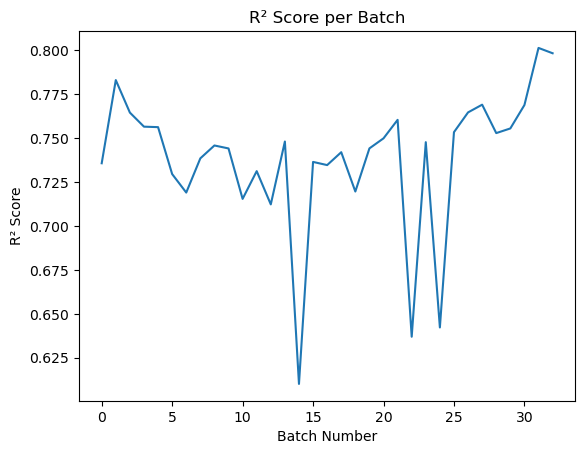

In [40]:
import matplotlib.pyplot as plt
plt.plot(r2_scores[:])
plt.xlabel("Batch Number")
plt.ylabel("R² Score")
plt.title("R² Score per Batch")
plt.show()